In [1]:
from nsetools import Nse
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import datetime as dt
from datetime import datetime
import pickle5 as pickle
import threading
import os
import json
import time

In [2]:
def get_unique_timestamps(df):
    allcolumns = list(df.iloc[:,1:].columns)
    timestamps = list()
    
    for column in allcolumns:
        time = column.split('@')[1]
        if time not in timestamps:
            timestamps.append(time)
        
    return timestamps 

In [3]:
def get_df_at_time_n_strikes(df, size ,time):
    columns = [df.columns[0]]
    for column in df.columns[1:]:
        if time in column:
            columns.append(column)
    somedata = df.loc[:,columns]
    
    nifty = dict()
    nifty['nifty'] = int(float(df.iloc[0,9]))
    nifty['time'] = time
    
    strike = nifty['nifty']-nifty['nifty']%50
    curtime = nifty['time']
    
    somedata = somedata.loc[strike-size*50:strike+size*50,:]

    return somedata

In [4]:
def extract_data_from_subdf(subdf,curtime):

    strike = subdf.iloc[int(subdf.shape[0]/2),0]
    sums = dict()
    sums['time'] = curtime
    sums['CE_OI'] = subdf.loc[:,'CE_OI_@'+curtime].sum()
    sums['PE_OI'] = subdf.loc[:,'PE_OI_@'+curtime].sum()
    sums['CE_CHOI'] = subdf.loc[:,'CE_CHOI_@'+curtime].sum()
    sums['PE_CHOI'] = subdf.loc[:,'PE_CHOI_@'+curtime].sum()
    sums['PE_CE_CHOI_DIFF'] = subdf.loc[:,'PE_CHOI_@'+curtime].sum() - subdf.loc[:,'CE_CHOI_@'+curtime].sum()
    sums['PCR'] = float(sums['PE_CHOI']/sums['CE_CHOI'])
    sums['CE_IO_INC'] =   float(sums['CE_CHOI'] / sums['CE_OI'])*100
    sums['PE_IO_INC'] =   float(sums['PE_CHOI'] / sums['PE_OI'])*100
    
    sums['nifty'] = subdf.iloc[0,9]
    
    return sums

In [5]:
def create_history(df,timestamps):
    for time in timestamps:
        subdf = get_df_at_time_n_strikes(df,6,time)
        history.append(extract_data_from_subdf(subdf,time))
    return history

In [6]:
def create_dataframe(history):
    newdf = pd.DataFrame()
    
    for i in range(len(history)):
        item = history[i]
        newdf.loc[i,'time'] = item['time']
        newdf.loc[i,'CE_CHOI'] = item['CE_CHOI']
        newdf.loc[i,'PE_CHOI'] = item['PE_CHOI']
        newdf.loc[i,'PE_CE_CHOI_DIFF'] = item['PE_CE_CHOI_DIFF']
        newdf.loc[i,'PCR'] = item['PCR']
        newdf.loc[i,'nifty'] = item['nifty']
        newdf.loc[i,'CE_IO_INC'] = item['CE_IO_INC']
        newdf.loc[i,'PE_IO_INC'] = item['PE_IO_INC']
        
    return newdf

In [7]:
def plot_subdf(df):
    plt.style.use("seaborn-darkgrid")
    plt.rcParams["figure.figsize"] = (30,10)
    plt.rcParams['xtick.labelsize'] = 5
    
    for col in df.columns[1:]:
        sns.scatterplot(x=df['time'],y=df[col],s=100)
        plt.show()

In [36]:
df = pd.read_csv('data.csv')
df.index = list(df.iloc[:,0])
try:
    df.drop(["Unnamed: 0"],axis =1,inplace=True)
except:
    pass
history = []

timestamps = get_unique_timestamps(df)
history = create_history(df,timestamps)
subdf = create_dataframe(history)

In [37]:
subdf

,time,CE_CHOI,PE_CHOI,PE_CE_CHOI_DIFF,PCR,nifty,CE_IO_INC,PE_IO_INC
0,09:36:51,962475.0,2089725.0,1127250.0,2.171199,13007.15,5.962126,16.578705
1,09:43:21,976350.0,2430375.0,1454025.0,2.489246,13012.05,6.042882,18.773862
2,09:51:21,813675.0,2812425.0,1998750.0,3.456448,13008.90,5.087265,21.102301
3,09:56:51,809250.0,3372075.0,2562825.0,4.166914,13029.15,5.060999,24.281849
4,10:03:51,949875.0,3639675.0,2689800.0,3.831741,13028.40,5.888671,25.713317
5,10:11:21,1072875.0,3820125.0,2747250.0,3.560643,13029.55,6.600866,26.648425
6,10:18:51,1064700.0,4207275.0,3142575.0,3.951606,13040.45,6.553865,28.577323
7,10:26:21,999375.0,4540650.0,3541275.0,4.543490,13036.65,6.176588,30.158809
8,10:33:21,1114350.0,4827150.0,3712800.0,4.331808,13032.50,6.838590,31.463014
9,10:39:22,870075.0,5316150.0,4446075.0,6.109991,13053.45,5.420775,33.579997


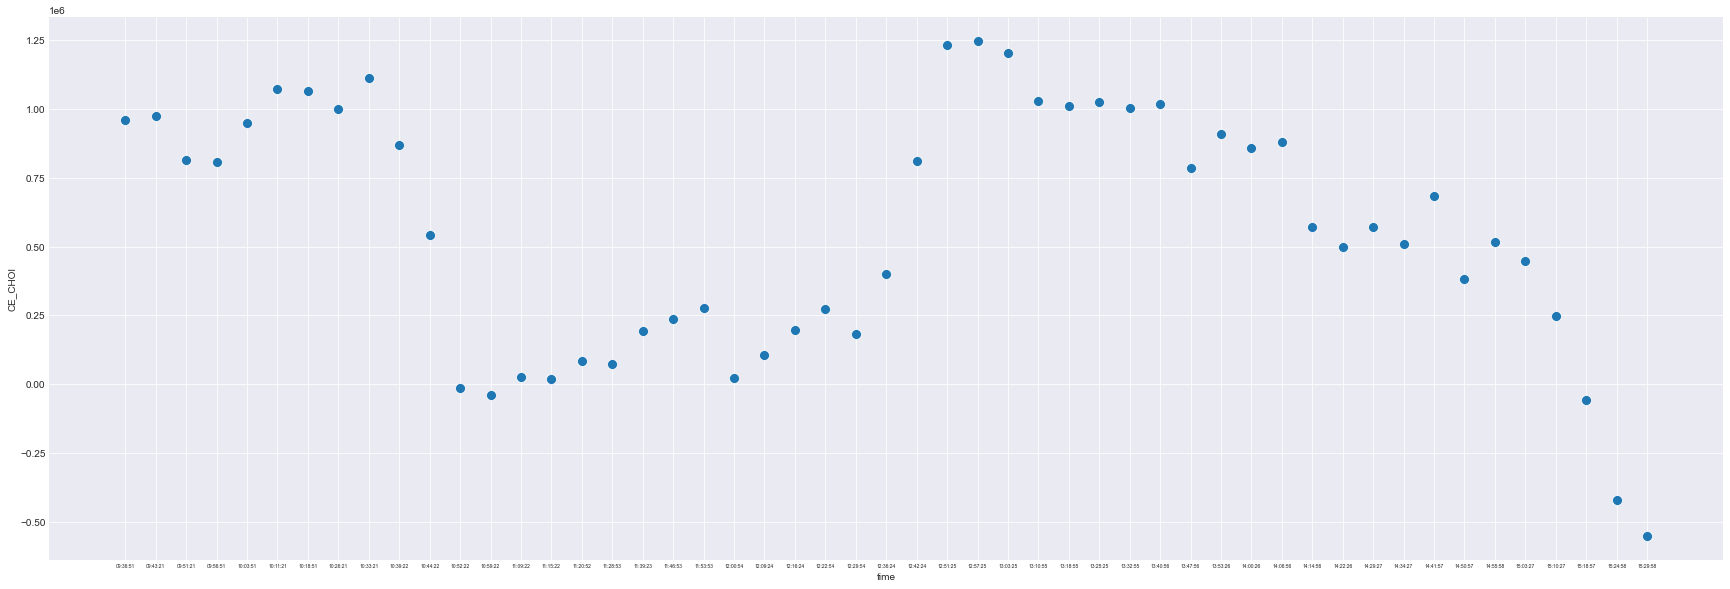

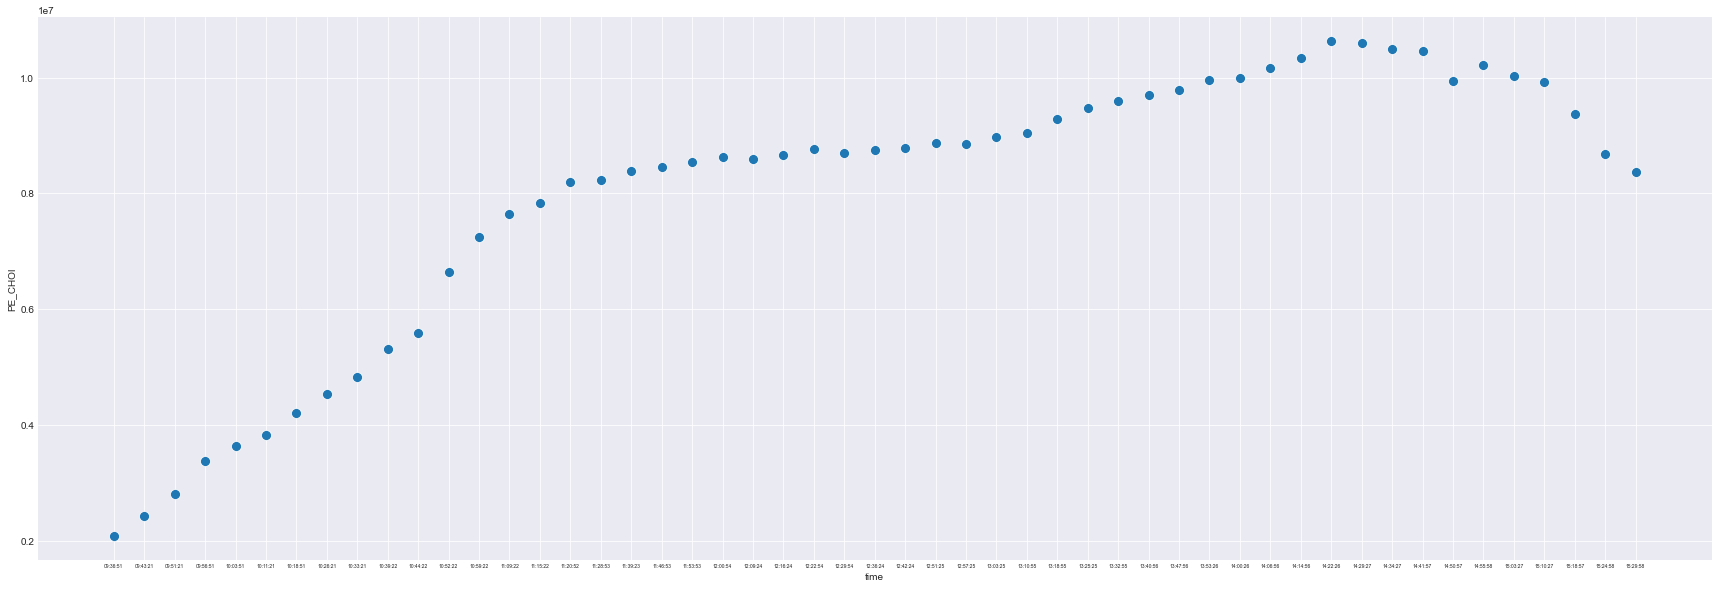

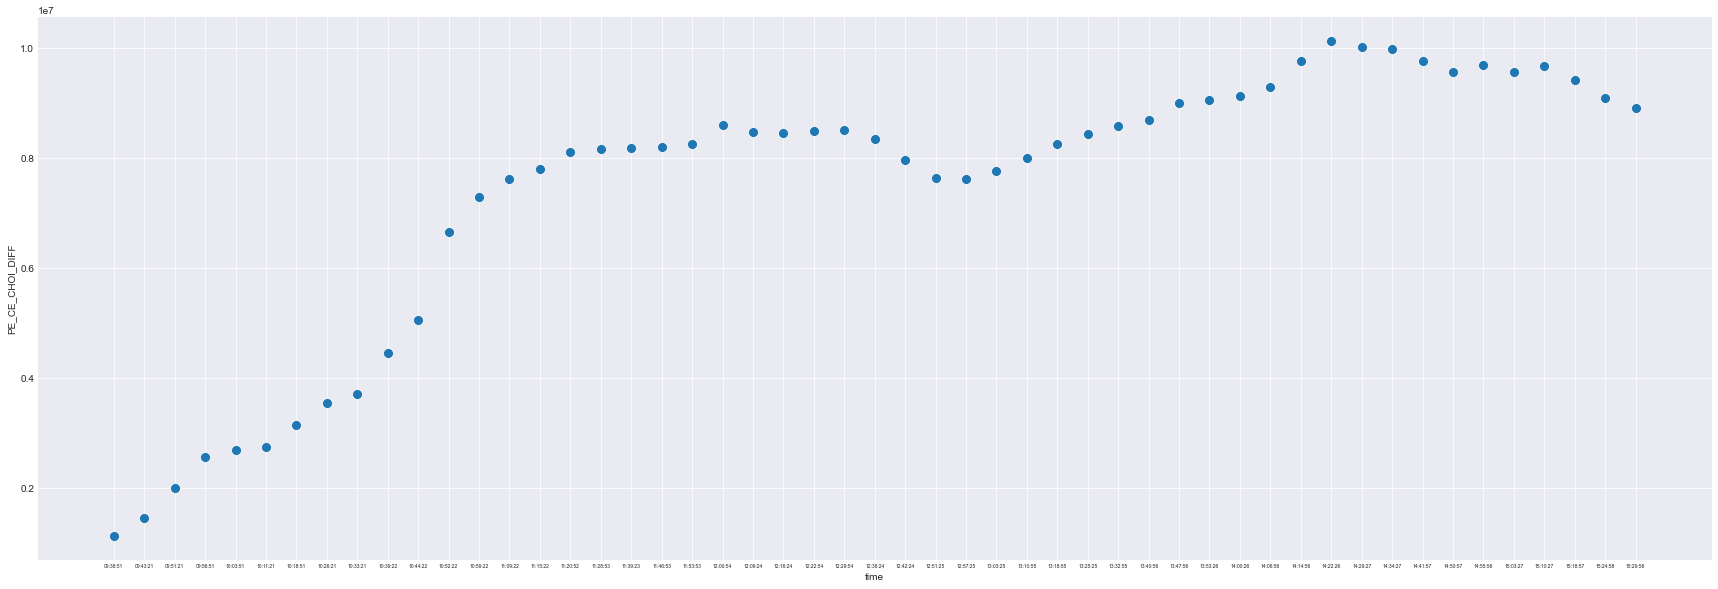

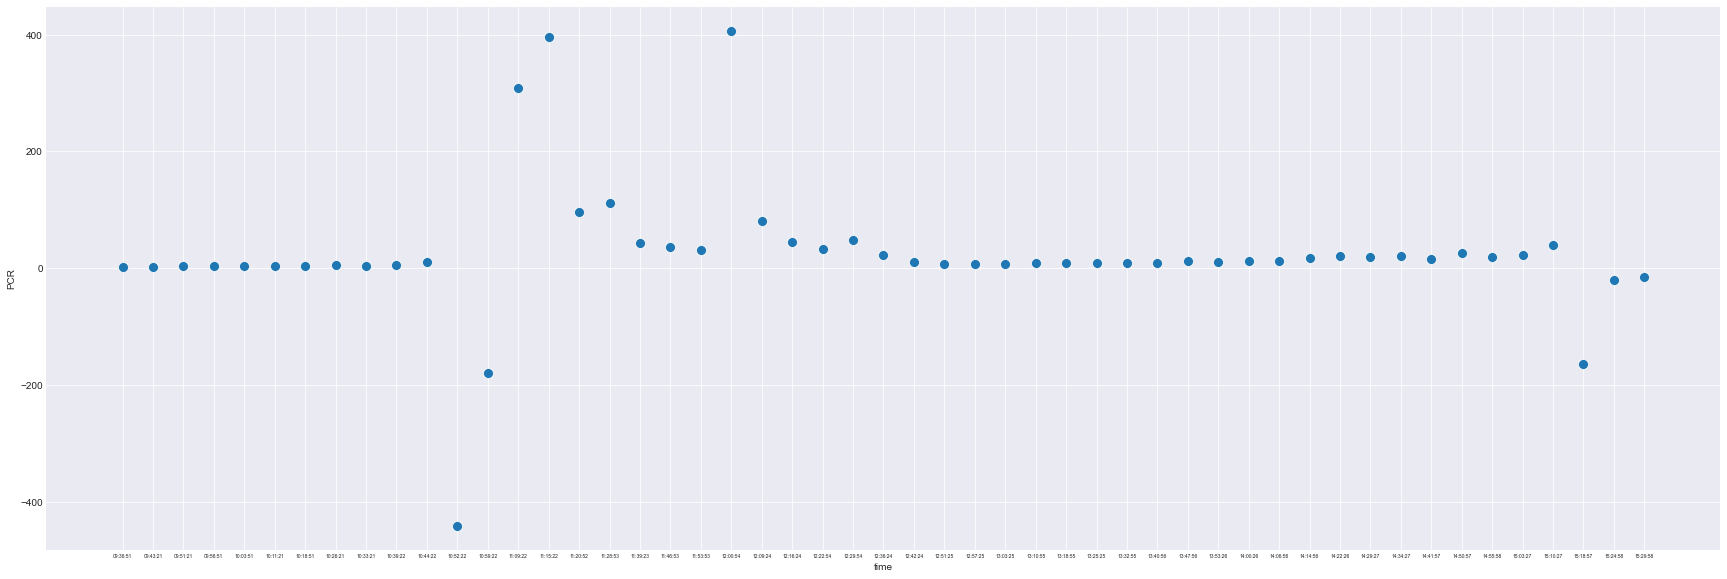

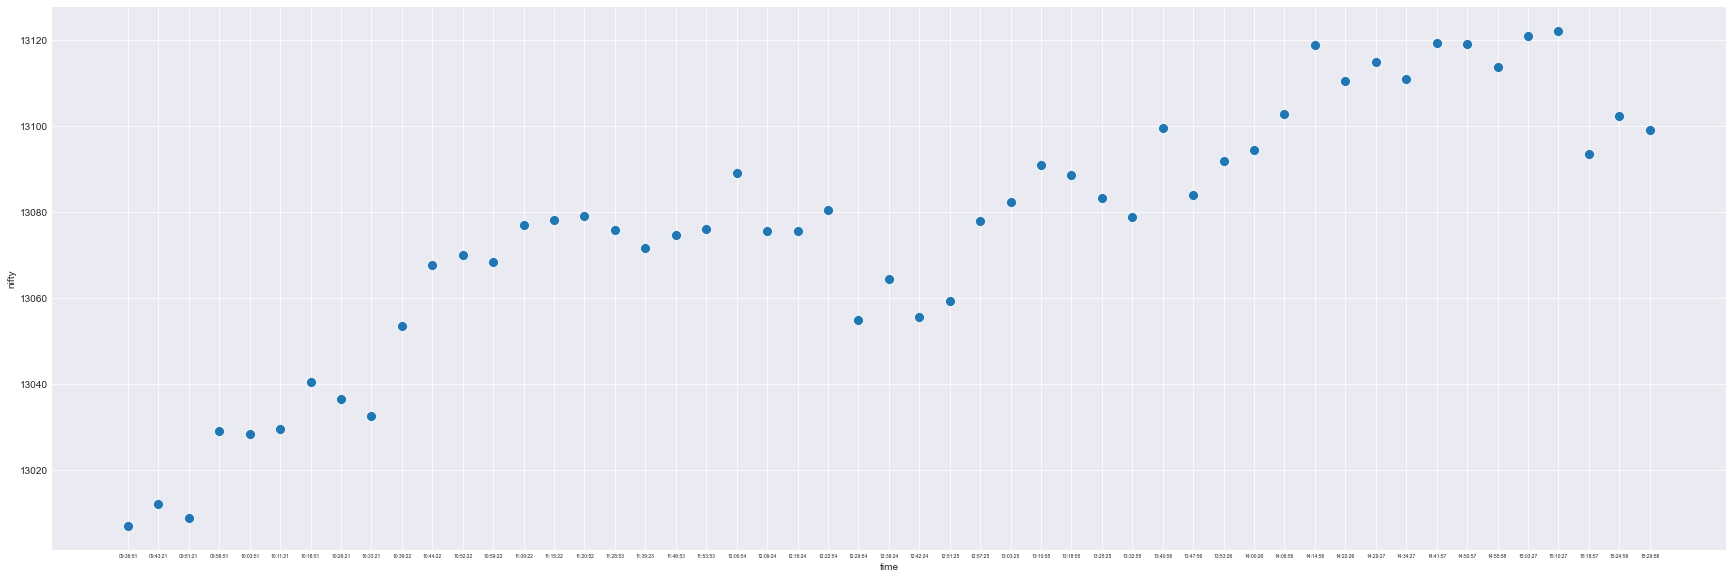

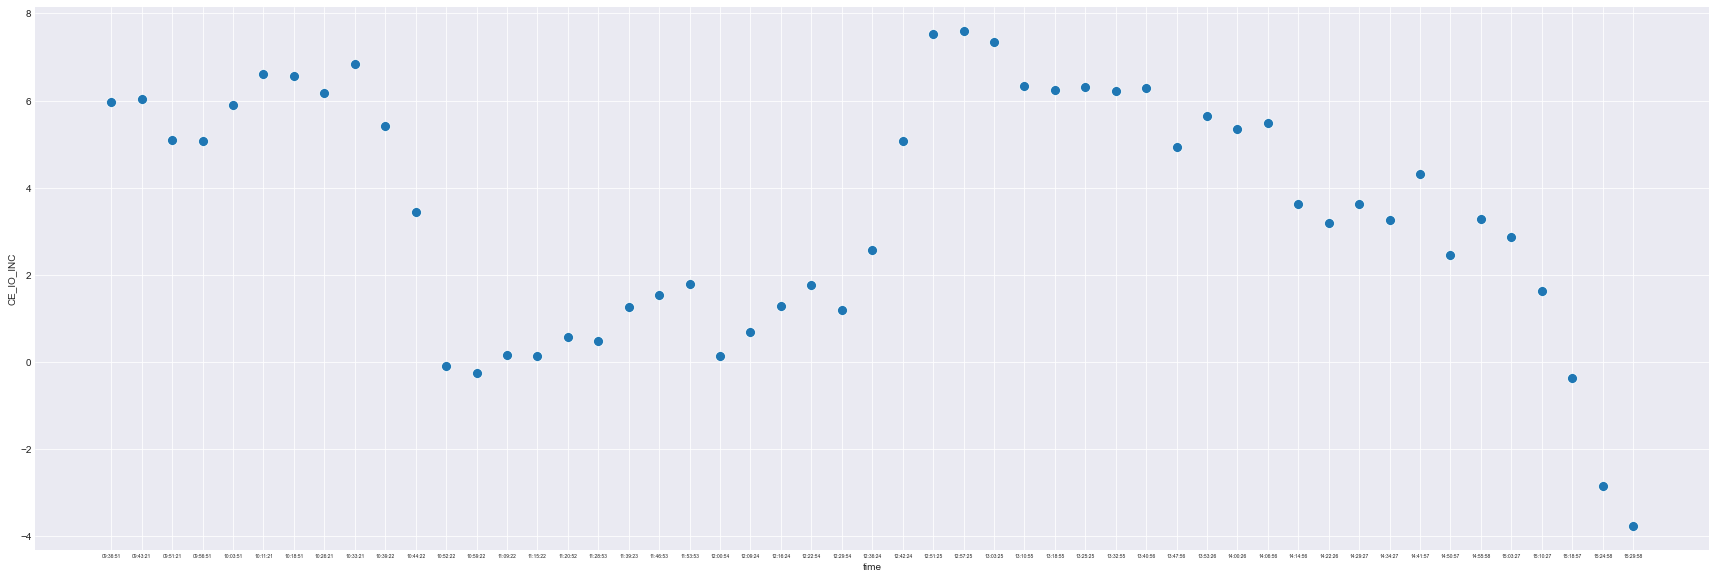

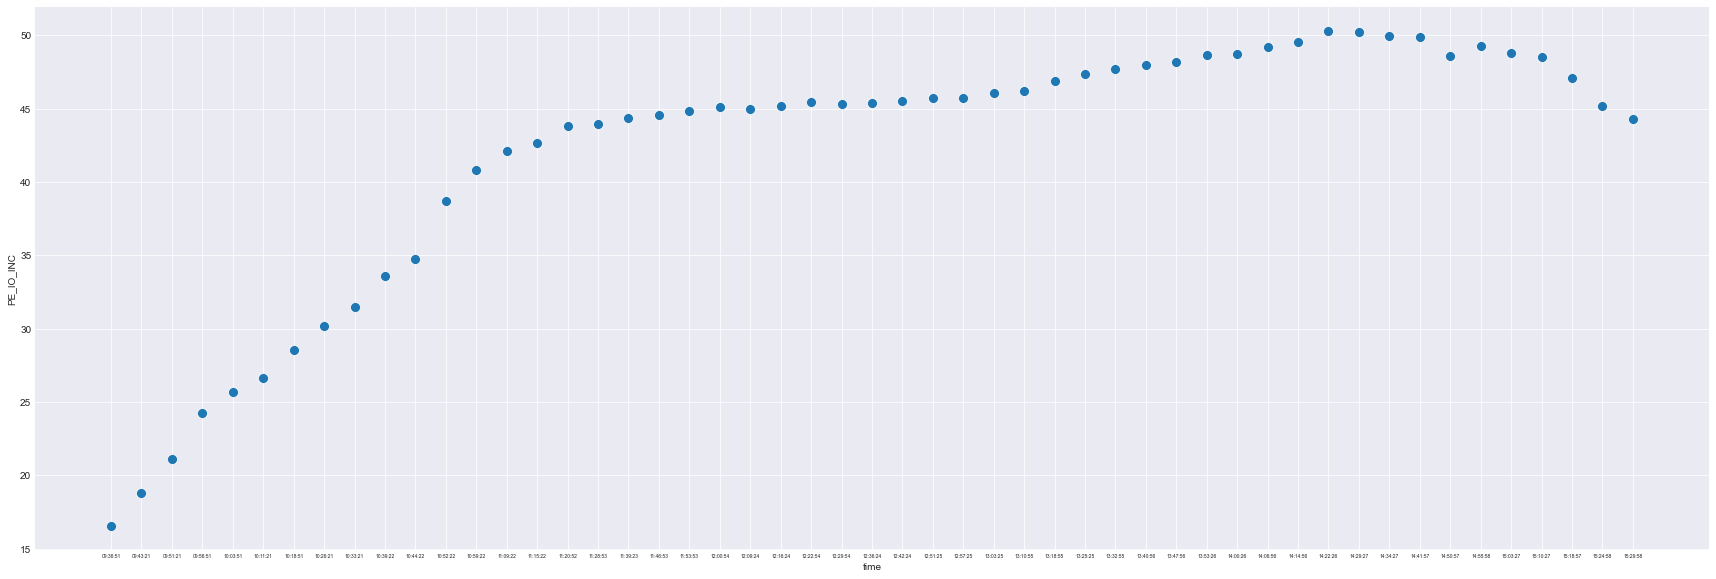

In [39]:
plot_subdf(subdf)

In [40]:
subdf.to_csv('oi_analysis.csv',index=False)

def greeks_and_rates(df):
    remove = list()
    for column in df.columns:
        if "IV" in column or "VOL" in column:
            remove.append(column)
    subdf = df.drop(remove,axis =1)
    return subdf

remove = []
for col in df.columns:
    if "LTP" in col or "NIFTY" in col:
        pass
    else:
        remove.append(col)
some = df.drop(remove,axis=1)


memory = dict:
for row in range(some.shape[0]):
    
    for column in range(some.shape[1])
        
        

some